In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
bs = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [4]:
z_dim = 100
mnist_dim = train_dataset.train_data.size(1)*train_dataset.train_data.size(2)

G = Generator(g_input_dim=z_dim, g_output_dim=mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

D:\anaconda\envs\tensorflow-gpu\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [6]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.001
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [8]:
def D_train(x):
    D.zero_grad()
    
    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output
    
    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))
    
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output
    
    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    return D_loss.data.item(), torch.mean(D_real_score).data.item(), torch.mean(D_fake_score).data.item()

In [9]:
def G_train(x):
    G.zero_grad()
    
    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))
    
    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)
    
    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
    
    return G_loss.data.item()

In [10]:
# # set up tensorboard
# from torch.utils.tensorboard import SummaryWriter

# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/mnist')

# # writing to tensorboard
# # get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # create grid of images
# img_grid = torchvision.utils.make_grid(images, 10)

# # write to tensorboard
# writer.add_image('mnist_images', img_grid)

# # show images
# img_grid = img_grid.mean(dim=0)
# img_grid = img_grid / 2 + 0.5     # unnormalize
# npimg = img_grid.numpy()
# plt.imshow(npimg, cmap="Greys")

# # tensorboard --logdir=runs --port=6006 --host=localhost
# # Inspect the model using TensorBoard
# writer.add_graph(Discriminator(784), images)
# writer.add_graph(Generator(100, 784), images)
# writer.close()

In [11]:
# Adding a “Projector” to TensorBoard
# def select_n_random(data, labels, n=100):
#     assert len(data) == len(labels)
#     perm = torch.randperm(len(data))
#     return data[perm][:n], labels[perm][:n]

# # select random images and their target indices
# images, labels = select_n_random(train_dataset.data, train_dataset.targets)

# # get the class labels for each image
# # constant for classes
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
# class_labels = [classes[lab] for lab in labels]

# # log embeddings
# features = images.view(-1, 28 * 28)
# writer.add_embedding(features,
#                     metadata=class_labels,
#                     label_img=images.unsqueeze(1))
# writer.close()

In [12]:
n_epoch = 20
D_losses, G_losses = [], []
real_scores, fake_scores = [], []
a_D_l, a_G_l, a_D_rs, a_D_fs = 0., 0., 0., 0.
fixed_noise = Variable(torch.randn(bs, z_dim).to(device))

In [13]:
for epoch in range(1, n_epoch+1):
    for batch_idx, (x, _) in enumerate(train_loader):
        D_l, D_rs, D_fs = D_train(x)
        G_l = G_train(x)
        
        a_D_l += D_l
        a_G_l += G_l
        a_D_rs += D_rs
        a_D_fs += D_fs
        if batch_idx % 100 == 99:
            D_losses.append(a_D_l/100)
            G_losses.append(a_G_l/100)
            real_scores.append(a_D_rs/100)
            fake_scores.append(a_D_fs/100)

            # ...log the running loss
#             writer.add_scalar('D loss',
#                             a_D_l / 100,
#                             epoch * len(train_loader) + batch_idx)
#             writer.add_scalar('G loss',
#                             a_G_l / 100,
#                             epoch * len(train_loader) + batch_idx)

            print('epoch[%d/%d][%d/%d]: loss_d: %.3f, loss_g: %.3f, D(x): %.3f, D(G(z)): %.3f' % 
                 (epoch, n_epoch, batch_idx, len(train_loader), a_D_l/100, a_G_l/100, a_D_rs/100, a_D_fs/100))
            
            a_D_l, a_G_l, a_D_rs, a_D_fs = 0., 0., 0., 0.
    
    # save models
    torch.save(G.state_dict(), './models/fc4/G.pth')
    torch.save(D.state_dict(), './models/fc4/D.pth')
    
    # save fake images
    with torch.no_grad():
        generated = G(fixed_noise)
        save_image(generated.view(generated.size(0), 1, 28, 28), './samples/fc4_samples/sample_%03d.png' % epoch, 10)

epoch[1/20][99/600]: loss_d: 1.410, loss_g: 0.724, D(x): 0.583, D(G(z)): 0.550
epoch[1/20][199/600]: loss_d: 1.394, loss_g: 0.849, D(x): 0.571, D(G(z)): 0.526
epoch[1/20][299/600]: loss_d: 1.367, loss_g: 1.346, D(x): 0.589, D(G(z)): 0.472
epoch[1/20][399/600]: loss_d: 1.284, loss_g: 0.911, D(x): 0.610, D(G(z)): 0.509
epoch[1/20][499/600]: loss_d: 1.334, loss_g: 0.786, D(x): 0.577, D(G(z)): 0.501
epoch[1/20][599/600]: loss_d: 1.292, loss_g: 0.811, D(x): 0.567, D(G(z)): 0.483
epoch[2/20][99/600]: loss_d: 1.294, loss_g: 0.852, D(x): 0.568, D(G(z)): 0.478
epoch[2/20][199/600]: loss_d: 1.306, loss_g: 0.881, D(x): 0.563, D(G(z)): 0.471
epoch[2/20][299/600]: loss_d: 1.306, loss_g: 0.841, D(x): 0.554, D(G(z)): 0.475
epoch[2/20][399/600]: loss_d: 1.314, loss_g: 0.873, D(x): 0.556, D(G(z)): 0.475
epoch[2/20][499/600]: loss_d: 1.308, loss_g: 0.871, D(x): 0.550, D(G(z)): 0.465
epoch[2/20][599/600]: loss_d: 1.255, loss_g: 0.971, D(x): 0.577, D(G(z)): 0.443
epoch[3/20][99/600]: loss_d: 1.294, loss_g

epoch[18/20][199/600]: loss_d: 0.239, loss_g: 4.583, D(x): 0.934, D(G(z)): 0.065
epoch[18/20][299/600]: loss_d: 0.224, loss_g: 4.673, D(x): 0.941, D(G(z)): 0.061
epoch[18/20][399/600]: loss_d: 0.740, loss_g: 3.931, D(x): 0.876, D(G(z)): 0.135
epoch[18/20][499/600]: loss_d: 0.467, loss_g: 3.704, D(x): 0.892, D(G(z)): 0.108
epoch[18/20][599/600]: loss_d: 0.304, loss_g: 4.038, D(x): 0.923, D(G(z)): 0.079
epoch[19/20][99/600]: loss_d: 0.285, loss_g: 4.254, D(x): 0.925, D(G(z)): 0.073
epoch[19/20][199/600]: loss_d: 0.316, loss_g: 3.900, D(x): 0.921, D(G(z)): 0.083
epoch[19/20][299/600]: loss_d: 0.466, loss_g: 3.867, D(x): 0.901, D(G(z)): 0.105
epoch[19/20][399/600]: loss_d: 0.528, loss_g: 4.014, D(x): 0.903, D(G(z)): 0.100
epoch[19/20][499/600]: loss_d: 0.324, loss_g: 4.065, D(x): 0.912, D(G(z)): 0.089
epoch[19/20][599/600]: loss_d: 0.214, loss_g: 4.498, D(x): 0.940, D(G(z)): 0.061
epoch[20/20][99/600]: loss_d: 0.249, loss_g: 4.620, D(x): 0.934, D(G(z)): 0.066
epoch[20/20][199/600]: loss_d:

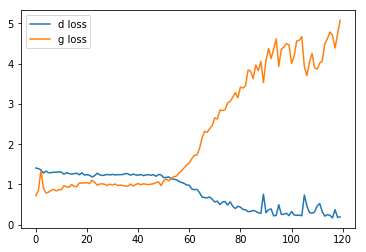

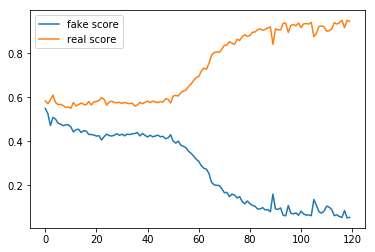

In [14]:
plt.figure()
plt.plot(D_losses, label='d loss')
plt.plot(G_losses, label='g loss')    
plt.legend()
plt.savefig('loss_fc4.png')
plt.show()

plt.figure()
plt.plot(fake_scores, label='fake score')
plt.plot(real_scores, label='real score')    
plt.legend()
plt.savefig('score_fc4.png')
plt.show()